In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import seaborn as sns

sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/")

import data_loader as dl

import get_layer_dict as gd


In [2]:
def condense_channel_matrix(tmp_X, df, case='between'):

    # combine units for each channel 
    new_matrix=np.zeros((len(depth_all), len(depth_all)))*np.NaN
    for i in range(len(depth_all)):
        for j in range(len(depth_all)):
            tmp_i = np.where((df.probe_id==new_probes[i]) & (df.channel_id==depth_all[i]))[0]
            tmp_j = np.where((df.probe_id==new_probes[j]) & (df.channel_id==depth_all[j]))[0]
            # removed within area
            if case=='between':
                if new_probes[i]!=new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='within':
                if new_probes[i]==new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='all':
                if len(tmp_i)>1 or len(tmp_j)>1:
                    amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                else:
                    amo = tmp_X[tmp_i, tmp_j]
                new_matrix[i,j]=amo
            else:
                print('case not specified!')
    return new_matrix

In [3]:
import networkx as nx
color_bank = {'probeA':'r',
                 'probeB':'brown',
                 'probeC': '#ff8c00',
                 'probeD': 'green',
                 'probeE': 'purple',
                 'probeF': 'blue'}

def plot_circle(t, r=1, center=[0,0]):
    x = r*np.cos(t) + center[0]
    y = r*np.sin(t) + center[1]
    return x, y

def set_nodes_position(df, depth_all, plot=False):  
    """
    set node location as function of channel id (depth)
    """
    n_nodes = len(depth_all)
    pos_probe={}
    pos_probe['probeC']=np.arange(250,310,0.6)/180.*np.pi
    pos_probe['probeD']=np.arange(180,240,0.6)/180.*np.pi
    pos_probe['probeE']=np.arange(120,180,0.6)/180.*np.pi
    pos_probe['probeF']=np.arange(60,120,0.6)/180.*np.pi
    pos_probe['probeA']=np.arange(0,60,0.6)/180.*np.pi
    pos_probe['probeB']=np.arange(310,360,0.4)/180.*np.pi


    probenames = df.probe_id.unique()
    t=[]
    for probe in probenames:
        chs = df[df.probe_id==probe].channel_id.unique()
        chs = chs-min(chs)
        if len(pos_probe[probe])>max(chs):
            t.append(pos_probe[probe][chs+1])
        else:
            print('Not enough nodes in '+probe+'. Add nodes!')
    t=np.concatenate(t, axis=0)
    print(len(t))

    pos={}
    for idx, a in enumerate(t):
        x, y = plot_circle(a)
        pos[idx]=np.array([x, y])

    if plot==True:
        FG = nx.Graph()
        # draw nodes
        for p in probenames:
            nx.draw_networkx_nodes(FG,pos,
                                   nodelist=list(probe_list[p]),
                                   node_color=color_bank[p],
                                   node_size=10,
                                   alpha=0.6)
        plt.axis('equal')

    # nodes id list for each probe
    probe_list={}
    for idx, probe in enumerate(probenames):
        probe_list[probe]=np.arange(n_nodes)[np.where(new_probes==probe)[0]]

    labels={}
    for i in range(n_nodes):
        labels[i]=int(depth_all[i])
    
    return pos, probe_list, labels

def set_nodes_position_within(df, probe, plot=False):  
    """
    set node location as function of channel id (depth) 
    clockwise s-m-d
    """

    pos_probe=np.arange(0-60, 360-60,4)/180.*np.pi

    chs = df[df.probe_id==probe].channel_id.unique()
    chs = chs-min(chs)
    if len(pos_probe)>max(chs):
        #t=np.concatenate([pos_probe[chs+1], [pos_probe[-1]]], axis=0)
        t=pos_probe[chs+1]
        
    else:
        print('Not enough nodes in '+probe+'. Add nodes!')

    pos={}
    for idx, a in enumerate(t):
        x, y = plot_circle(a)
        pos[idx]=np.array([x, y])

    if plot==True:
        FG = nx.Graph()
        # draw nodes
        nx.draw_networkx_nodes(FG, pos,
                               nodelist=range(len(t)),
                               node_color=color_bank[probe],
                               node_size=10,
                               alpha=0.6)
        plt.axis('equal')
    return pos

In [4]:
def inout_index(n_positive, n_negative):
    """
    compute index for connection going out of an source area or back to a source area
    "this is actually out-in index"
    """
    if n_positive+n_negative>0:
        return (n_positive-n_negative)/float(n_positive+n_negative)
    else:
        return np.NaN

# plot example graph with in/out index

415149
140
140
140
140


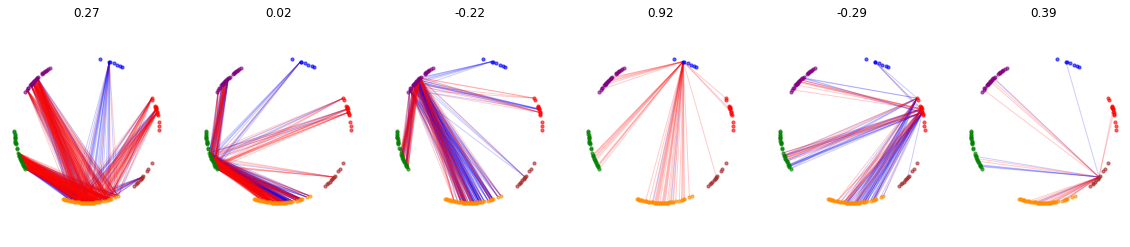

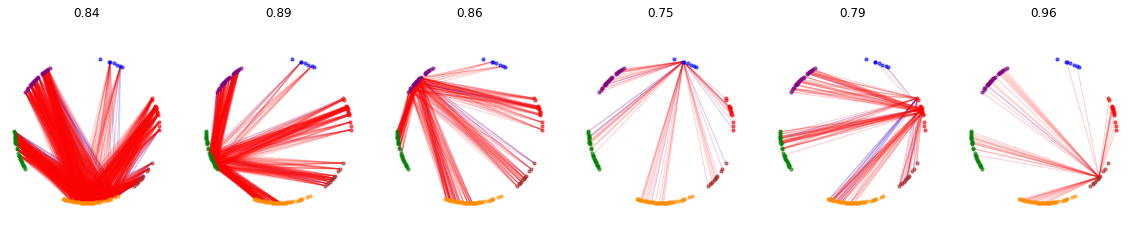

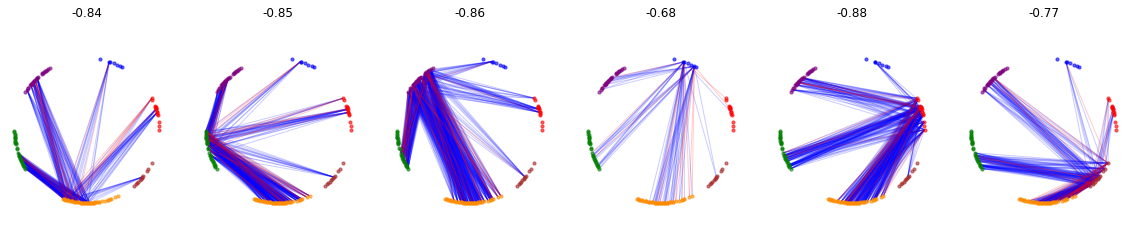

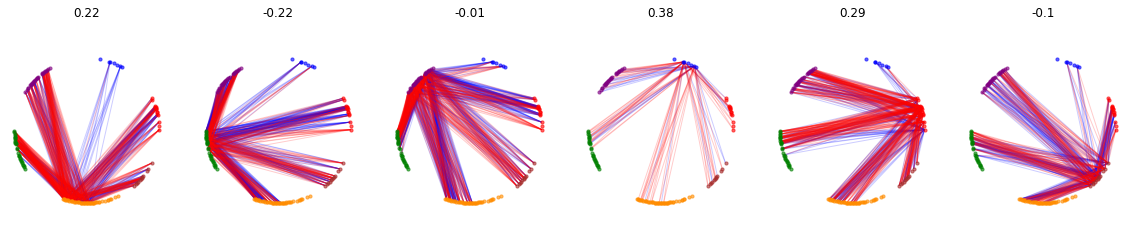

In [7]:
#between area
probe_reorder = ['probeC','probeD','probeE','probeF','probeA','probeB']
#threshold for visualization purpose
threshold=0.0000002 #0.000001

mouse_IDs = ['415149'] 

AMO=[]
for mouse_ID in mouse_IDs:
    print(mouse_ID)
    # 1. load df
    X = np.load('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/data/Fig5_6/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
    
    #from denoise_matrix import denoise_matrix
    #X, k, threshold = denoise_matrix(X, threshold=0.95, plot=True)
        
    df = pd.read_csv('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/data/Fig5_6/mouse'+mouse_ID+'_meta_cluster_RF.csv')
    
    # get unique depth for each probe
    depth={}
    depth_all=[]
    new_probes=[]
    probenames = df.probe_id.unique()
    for probe in probenames:
        tmp = df[df.probe_id==probe].channel_id.unique()
        depth[probe]=list(tmp)
        depth_all.append(list(tmp))
        new_probes.append([probe]*len(tmp))
    depth_all = np.concatenate(depth_all, axis=0)
    new_probes = np.concatenate(new_probes, axis=0)
    n_nodes = len(depth_all)
    
    case='between'
    
    index_amo=np.zeros((2,2,6))*np.NaN
    for m in [2,3]:
        for n in [2,3]:
            matrix = X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]
            tmp_X=np.zeros(np.shape(X))
            tmp_X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]=matrix

            new_matrix = condense_channel_matrix(tmp_X, df, case=case)
            pos, probe_list, labels = set_nodes_position(df, depth_all)
            
                        # for abstract figure with selected interarea connections
            
            plt.figure(figsize=(20,4))
            for idx, probe in enumerate(probe_reorder):
                plt.subplot(1,6,idx+1)
                FG = nx.Graph()
                # draw nodes
                for p in probenames:
                    nx.draw_networkx_nodes(FG,pos,
                                           nodelist=list(probe_list[p]),
                                           node_color=color_bank[p],
                                           node_size=10,
                                           alpha=0.6)
                plt.axis('equal')

                edgeP=new_matrix
                # add positive edge
                if probe in probenames:
                    for i in probe_list[probe]:
                        for j in range(n_nodes):
                            if i!=j:
                                if abs(edgeP[i,j])>0.0000001:
                                    FG.add_weighted_edges_from([(i,j, edgeP[i,j])])
                    
                    # need to count number of connections after the whole graph is generated
                    negative=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] <-threshold]
                    nx.draw_networkx_edges(FG,pos,edgelist=negative,width=1,edge_color='b', alpha=0.2)

                    positive=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] >threshold]
                    nx.draw_networkx_edges(FG,pos,edgelist=positive,width=1,edge_color='r', alpha=0.2)

                    amo = inout_index(len(positive), len(negative))
                    index_amo[m-2, n-2, idx]=amo

                    plt.axis('off')
                    plt.title(round(amo,2))

    AMO.append(index_amo)

# Compute out-in index in subnetworks 

In [6]:
mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356','416861','419112','419116']

probe_reorder= ['probeC', 'probeF','probeD','probeE','probeB','probeA']

# test different threshold
thresholds=[0, 0.0000001, 0.0000005, 0.000001, 0.000002, 0.000005] #0.000001


AMO_all=[]
for threshold in thresholds:
    AMO=[]
    for mouse_ID in mouse_IDs:
        print(mouse_ID)
        # 1. load df
        X = np.load('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/data/Fig3/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')

        #from denoise_matrix import denoise_matrix
        #X, k, threshold = denoise_matrix(X, threshold=0.95, plot=True)

        df = pd.read_csv('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/data/Fig3/mouse'+mouse_ID+'_meta_cluster_RF.csv')

        # get unique depth for each probe
        depth={}
        depth_all=[]
        new_probes=[]
        probenames = df.probe_id.unique()
        for probe in probenames:
            tmp = df[df.probe_id==probe].channel_id.unique()
            depth[probe]=list(tmp)
            depth_all.append(list(tmp))
            new_probes.append([probe]*len(tmp))
        depth_all = np.concatenate(depth_all, axis=0)
        new_probes = np.concatenate(new_probes, axis=0)
        n_nodes = len(depth_all)

        case='between'

        index_amo=np.zeros((2,2,6))*np.NaN
        for m in [2,3]:
            for n in [2,3]:
                matrix = X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]
                tmp_X=np.zeros(np.shape(X))
                tmp_X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]=matrix

                new_matrix = condense_channel_matrix(tmp_X, df, case=case)
                pos, probe_list, labels = set_nodes_position(df, depth_all)

                for idx, probe in enumerate(probe_reorder):
                    FG = nx.Graph()
                    edgeP=new_matrix
                    # add positive edge
                    if probe in probenames:
                        for i in probe_list[probe]:
                            for j in range(n_nodes):
                                if i!=j:
                                    if abs(edgeP[i,j])>threshold:
                                        FG.add_weighted_edges_from([(i,j, edgeP[i,j])])

                        # need to count number of connections after the whole graph is generated
                        negative=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] <-threshold]
                        positive=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] >threshold]

                        amo = inout_index(len(positive), len(negative))
                        index_amo[m-2, n-2, idx]=amo

        AMO.append(index_amo)
    AMO=np.array(AMO)
    AMO_all.append(AMO)
#np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/inout_index/threshold0000001_19mice.npy', [AMO, probe_reorder])



306046
154
154
154
154
388523
120
120
120
120
389262
84
84
84
84
408153
139
139
139
139
410344
132
132
132
132
415149
140
140
140
140
412809
134
134
134
134
412804
106
106
106
106
416856
123
123
123
123
419114
168
168
168
168
419117
115
115
115
115
419118
126
126
126
126
419119
133
133
133
133
424445
130
130
130
130
415148
137
137
137
137
416356
126
126
126
126
416861
179
179
179
179
419112
150
150
150
150
419116
159
159
159
159
306046
154
154
154
154
388523
120
120
120
120
389262
84
84
84
84
408153
139
139
139
139
410344
132
132
132
132
415149
140
140
140
140
412809
134
134
134
134
412804
106
106
106
106
416856
123
123
123
123
419114
168
168
168
168
419117
115
115
115
115
419118
126
126
126
126
419119
133
133
133
133
424445
130
130
130
130
415148
137
137
137
137
416356
126
126
126
126
416861
179
179
179
179
419112
150
150
150
150
419116
159
159
159
159
306046
154
154
154
154
388523
120
120
120
120
389262
84
84
84
84
408153
139
139
139
139
410344
132
132
132
132
415149
140
140
140
140


In [13]:
# save all 
AMO_all = np.array(AMO_all)
np.save('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/inout_index_threshold.npy', AMO_all)
np.save('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/thresholds.npy', thresholds)


In [16]:
thresholds

[0, 1e-07, 5e-07, 1e-06, 2e-06, 5e-06]

In [5]:
AMO_all = np.load('/Users/xiaoxuanj/Dropbox/2019 information_flow_paper/Neuron submission/second_submission/inout_index_threshold.npy')
AMO_all.shape

(6, 19, 2, 2, 6)

In [18]:
from scipy.stats import linregress, pearsonr, spearmanr

tmp = -AMO_all[0,:,1,1,:]
tmp.shape
X = [-0.50149, -0.13929, -0.12294, -0.00431, 0.11828, 0.29330] # CC-CT-TC global HS from Harris
Y = np.nanmean(tmp, axis=0)
r_s,p_s = spearmanr(X,Y)
r_p,p_p = pearsonr(X,Y)

text = '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,10)) + '\n' + \
          '$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,10))
print(text)

$r_S$ = 0.6; $P_S$ = 0.208
$r_P$ = 0.61; $P_P$ = 0.1985802352


In [19]:
Y

array([-0.07227631, -0.18663129, -0.07852414, -0.08462539,  0.00325689,
        0.06446895])

$r_S$ = 0.83; $P_S$ = 0.0415626822
$r_P$ = 0.83; $P_P$ = 0.0422106233
$r_S$ = 0.83; $P_S$ = 0.0415626822
$r_P$ = 0.81; $P_P$ = 0.0491963144
$r_S$ = 0.94; $P_S$ = 0.0048046647
$r_P$ = 0.84; $P_P$ = 0.0356961051
$r_S$ = 0.94; $P_S$ = 0.0048046647
$r_P$ = 0.88; $P_P$ = 0.0218365693
$r_S$ = 0.89; $P_S$ = 0.018845481
$r_P$ = 0.87; $P_P$ = 0.0254997243
$r_S$ = 0.77; $P_S$ = 0.0723965015
$r_P$ = 0.73; $P_P$ = 0.0985624116


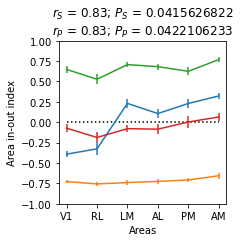

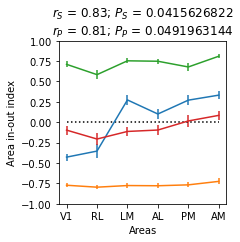

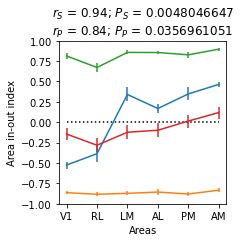

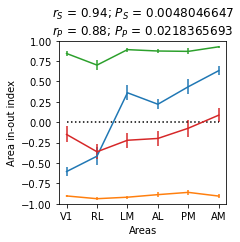

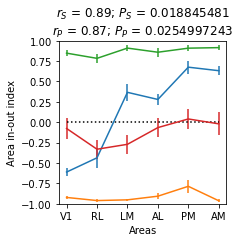

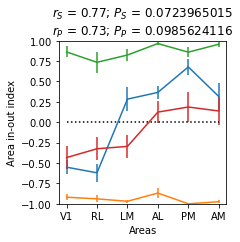

In [37]:
from scipy.stats import linregress, pearsonr, spearmanr
areas = ['V1','RL','LM','AL','PM','AM']
#X = [ -0.357,  -0.059, -0.093,   0.152,0.327, 0.441] # platform paper
X = [-0.50149, -0.13929, -0.12294, -0.00431, 0.11828, 0.29330] # CC-CT-TC global HS from Harris

#for t in ids:
    #[AMO, probe_reorder] = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/inout_index/threshold'+t+'.npy', allow_pickle=True)

for idx in range(6):
    AMO = AMO_all[idx]
    plt.figure(figsize=(3,3))
    for i in range(2):
        for j in range(2):
            m=np.nanmean(-AMO[:,i,j,:], axis=0)
            s=np.nanstd(-AMO[:,i,j,:], axis=0)/np.sqrt(AMO.shape[0])
            plt.errorbar(areas, m, s, label=str(i)+' '+str(j))
    plt.xlabel('Areas')
    plt.ylabel('Area in-out index')
    #plt.title('Threshold '+str(thresholds[idx]))
    plt.plot([0,5],[0,0],':k')
        
    m=np.nanmean(-AMO[:,0,0,:], axis=0)
    Y = m

    r_s,p_s = spearmanr(X,Y)
    r_p,p_p = pearsonr(X,Y)

    text = '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,10)) + '\n' + \
              '$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,10))

    plt.title(text)
    plt.ylim([-1,1])
    print(text)


R-squared: 0.371984
$r_P$ = 0.61; $P_P$ = 0.19858
$r_S$ = 0.6; $P_S$ = 0.208


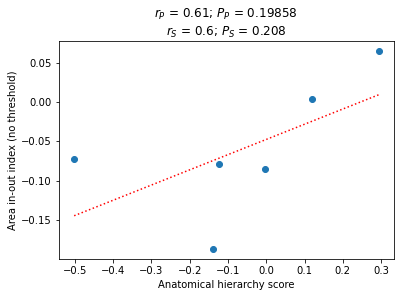

In [6]:
HS = [-0.50149, -0.13929, -0.12294, -0.00431, 0.11828, 0.29330] # CC-CT-TC global HS from Harris

from scipy.stats import linregress, pearsonr, spearmanr

idx=0
means_frank = []
# Spearman's correlation with each area's HS from Harris paper (global hierarchy score)
AMO = AMO_all[idx]

means_frank=np.nanmean(-AMO[:,0,0,:], axis=0)
        
plt.scatter(HS, means_frank )

res = linregress(HS, means_frank)
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(HS, res.intercept + res.slope*np.array(HS), ':r', label='fitted line')

r_s,p_s = spearmanr(HS, means_frank)
r_p,p_p = pearsonr(HS, means_frank)
print('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.title('$r_P$ = ' + str(np.around(pow(r_p,1),2)) + '; $P_P$ = ' + str(np.around(p_p,6)) + '\n' + \
            '$r_S$ = ' + str(np.around(pow(r_s,1),2)) + '; $P_S$ = ' + str(np.around(p_s,6)))
plt.ylabel('Area in-out index (no threshold)')
plt.xlabel('Anatomical hierarchy score')

